By [Kevin Michalewicz](https://kevinmichalewicz.com) on May 2023

This notebook analyses the accuracy of affinity predictions when using structures folded by AlphaFold.

In [1]:
# General imports
import cv2
import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import subprocess
import torch

from copy import deepcopy
from matplotlib.colors import CenteredNorm

# ANTIPASTI
from antipasti.preprocessing.preprocessing import Preprocessing
from antipasti.utils.explaining_utils import plot_map_with_regions
from antipasti.utils.torch_utils import load_checkpoint

# Loading all the test samples (original and predicted with AlphaFold)

In [2]:
modes = 'all'
n_filters = 4
filter_size = 4
pooling_size = 1
n_max_epochs = 1044

pathological = ['5omm', '5i5k', '1uwx', '1mj7', '1qfw', '1qyg', '4ffz', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t', '3fku', '1oau', '1oay'] + ['4gqp', '3etb', '3gkz', '3uze', '3uzq', '3gm0', '4f9l', '6ejg', '6ejm', '1h8s', '5dfw', '6cbp', '4f9p', '5kov', '1dzb', '5j74', '5aaw', '3uzv', '5aam', '3ux9', '5a2j', '5a2k', '5a2i', '3fku', '5yy4', '3uyp', '5jyl', '1y0l', '1p4b', '3kdm', '4lar', '4ffy', '2ybr', '1mfa', '5xj3', '5xj4', '4kv5', '5vyf'] 
stage = 'predicting'
dccm_map_path = 'dccm_maps_full_ags_all/'

test_data_path = '../notebooks/test_data/'
test_dccm_map_path = 'dccm_map/'
test_residues_path = 'list_of_residues/'
test_structure_path = 'structure/'

test_pdbs = ['8g8n', '8ipc', '7yp2', '8jlx', '8b7h', '7y3o', '8x0t', '8t9z', '8hes', '8f9u', '8f5i', '8eli', '8fgx', '7trh', '8ag1', '8byu', '8pe9', '8ivx', '8f6o', '8av9', '8hn6'] 

original_structures = []
af_pred_structures = []  
    
for test_pdb, h_offset, l_offset in zip(test_pdbs, h_offset_list, l_offset_list):
    print(test_pdb)
    preprocessed_data = Preprocessing(dccm_map_path=dccm_map_path, modes=modes, pathological=pathological, stage=stage, test_data_path=test_data_path, test_dccm_map_path=test_dccm_map_path, test_residues_path=test_residues_path, test_structure_path=test_structure_path, test_pdb_id=test_pdb, renew_residues=True, alphafold=False)
    original_structures.append(preprocessed_data.test_x)
    
    preprocessed_data = Preprocessing(dccm_map_path=dccm_map_path, modes=modes, pathological=pathological, stage=stage, test_data_path=test_data_path, test_dccm_map_path=test_dccm_map_path, test_residues_path=test_residues_path, test_structure_path=test_structure_path, test_pdb_id=test_pdb+'_af', alphafold=True)
    af_pred_structures.append(preprocessed_data.test_x)
    
input_shape = preprocessed_data.test_x.shape[-1]

8g8n
8ipc
7yp2
8jlx
8b7h
7y3o
8x0t
8t9z
8hes
8f9u
8f5i
8eli
8fgx
7trh
8ag1
8byu
8pe9
8ivx
8f6o
8av9
8hn6


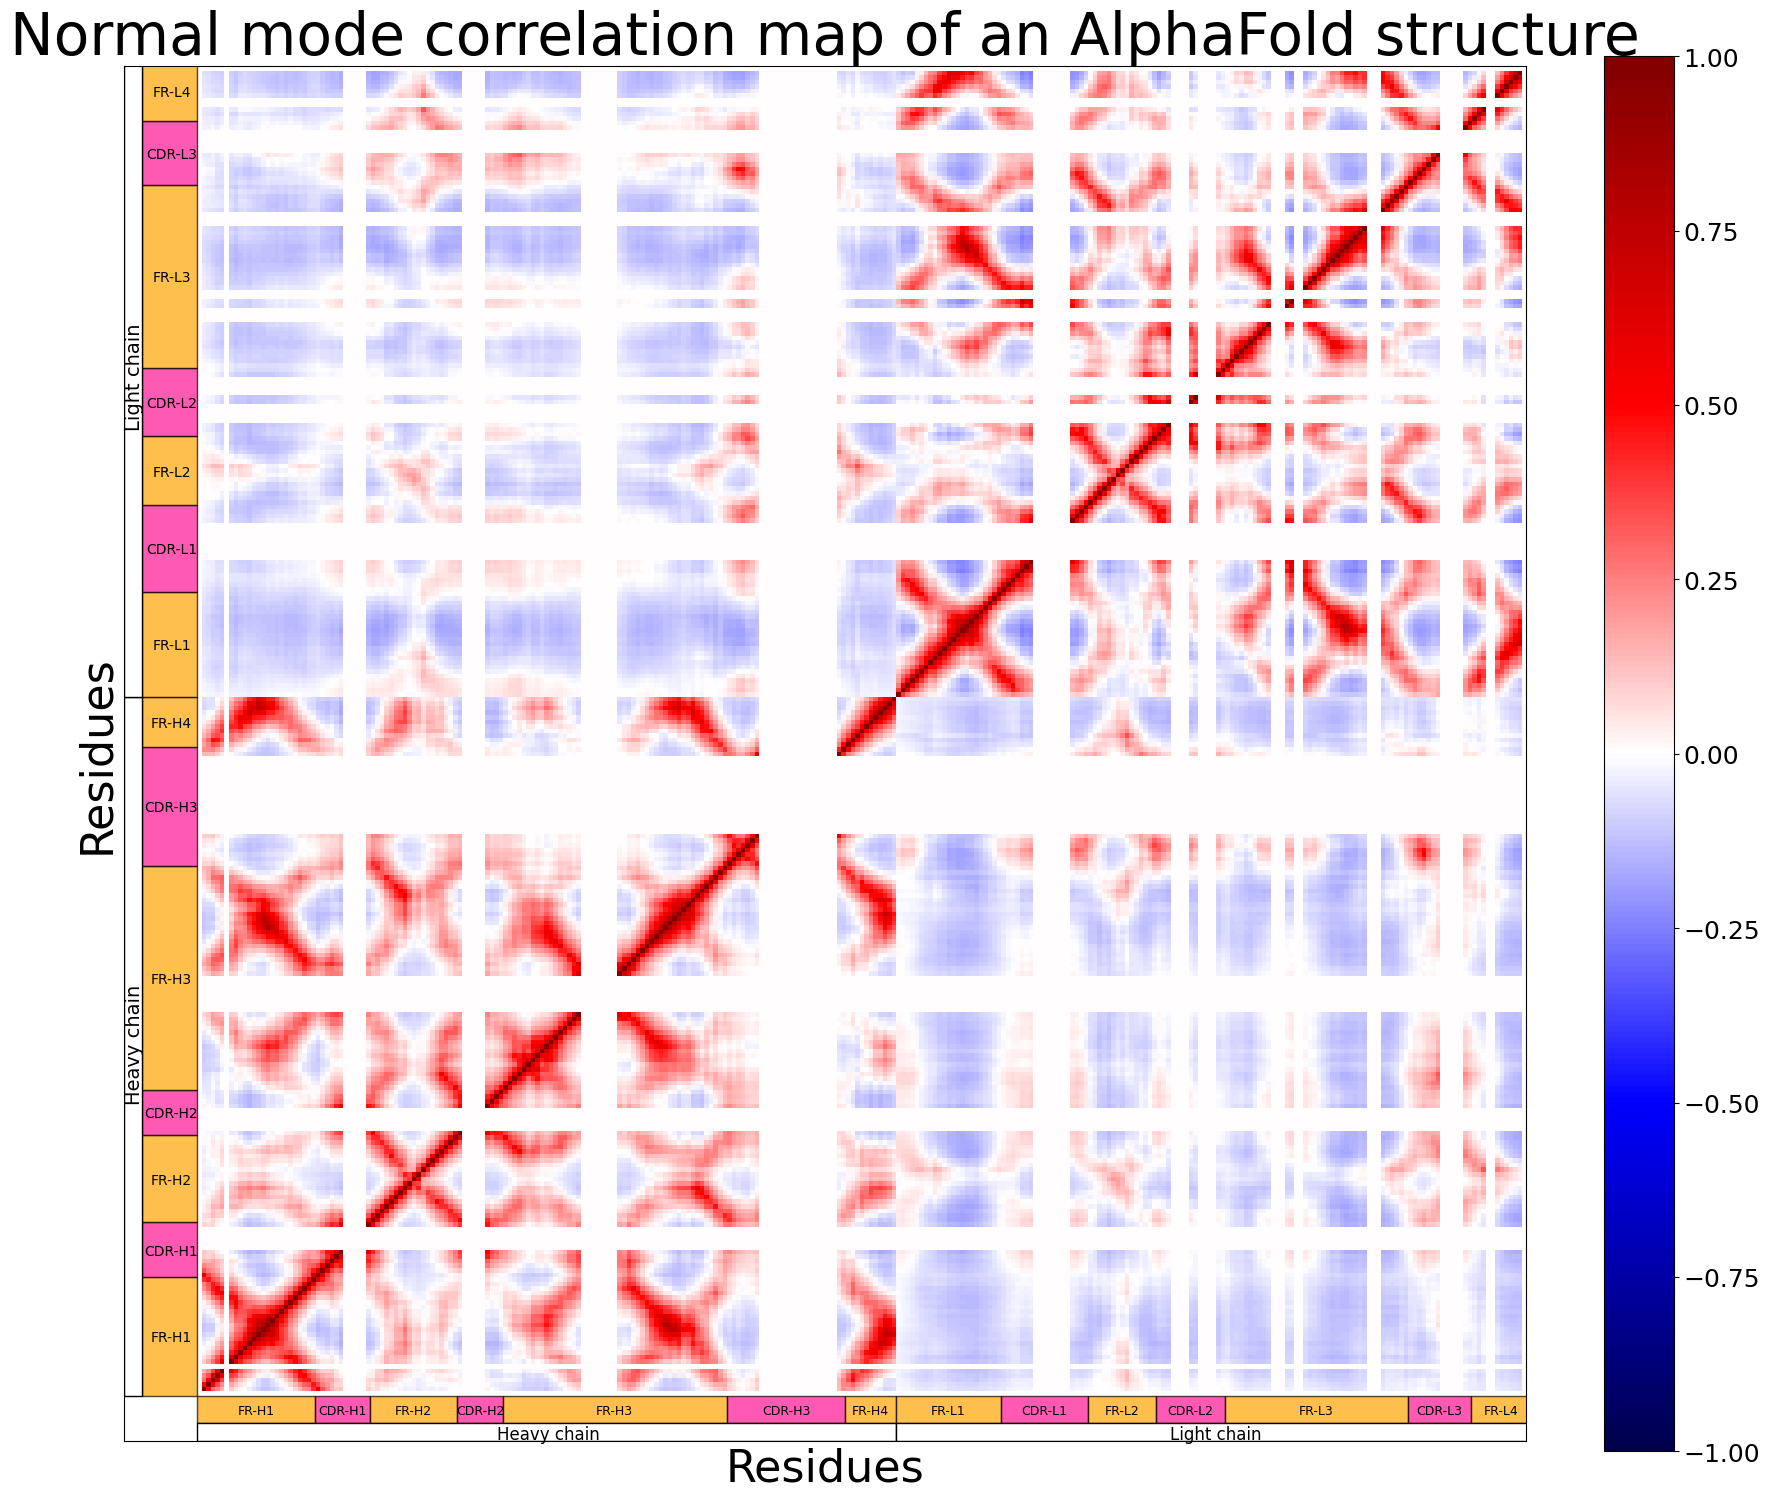

In [3]:
plot_map_with_regions(preprocessed_data, preprocessed_data.test_x, title='Normal mode correlation map of an AlphaFold structure')

# Loading an ANTIPASTI checkpoint

In [4]:
path = '../checkpoints/full_ags_all_modes/model_' + 'epochs_' + str(n_max_epochs) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
model = load_checkpoint(path, input_shape)[0]
model.eval()

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


ANTIPASTI(
  (conv1): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=334084, out_features=1, bias=False)
)

# Predicting the binding affinity

In [5]:
# We convert to the torch format and predict
kds_original = [model(torch.from_numpy(test_arr.reshape(1, 1, input_shape, input_shape).astype(np.float32)))[0].detach().numpy()[0,0] for test_arr in original_structures]
kds_af_pred = [model(torch.from_numpy(test_arr.reshape(1, 1, input_shape, input_shape).astype(np.float32)))[0].detach().numpy()[0,0] for test_arr in af_pred_structures]
corr_coeff = np.corrcoef(kds_original, kds_af_pred)[1,0]

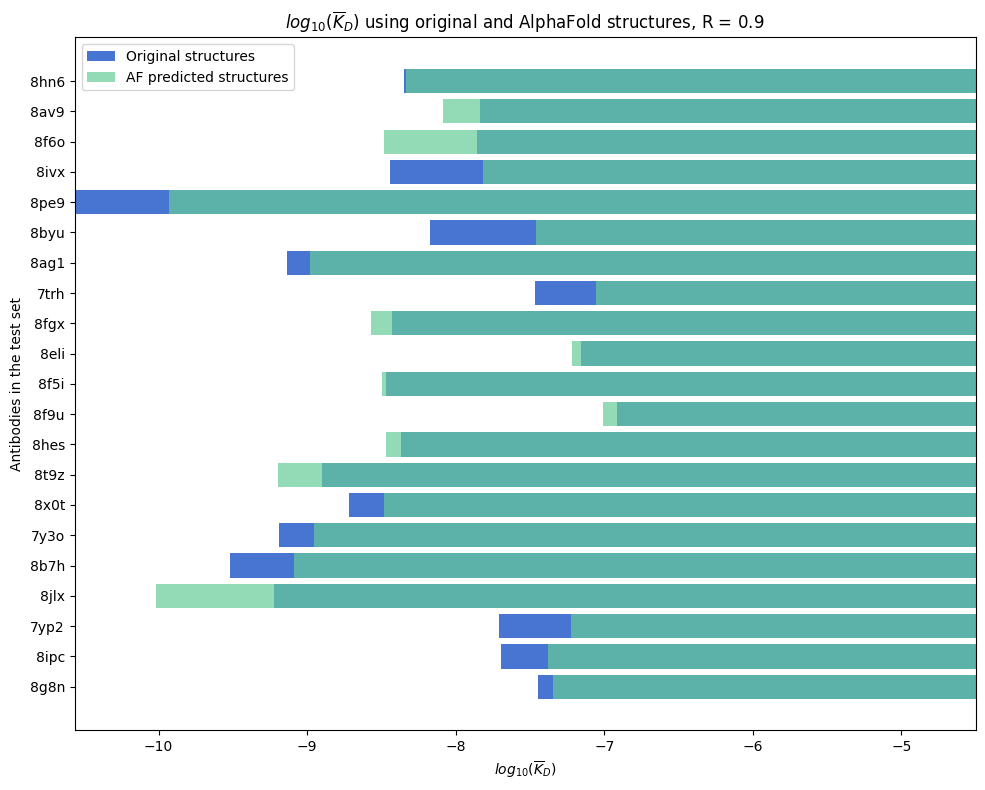

In [6]:
# Horizontal bar chart
fig = plt.figure(figsize=(10, 8))
y_pos = np.arange(len(test_pdbs))
plt.barh(y_pos, kds_original, align='center', alpha=0.9, label='Original structures', color='#3366cc')
plt.barh(y_pos, kds_af_pred, align='center', alpha=0.7, label='AF predicted structures', color='#66cc99')

# Add labels, title, and legend
plt.xlabel(r'$log_{10}(\overline{K}_D)$')
plt.ylabel(r'Antibodies in the test set')
plt.title(r'$log_{10}(\overline{K}_D)$ using original and AlphaFold structures, R = '+str(round(corr_coeff, 2)))
plt.yticks(y_pos, test_pdbs)
plt.legend()
plt.tight_layout()

# x-axis going from the minimum to -4.5
min_kd = min(min(kds_original), min(kds_af_pred))
plt.xlim(min_kd, -4.5)

plt.show()

In [187]:
# Difference of log10(Kd) from original structures and AlphaFold predictions
kds_difference = np.array([kds_original[i] - kds_af_pred[i] for i in range(len(kds_original))])

# Max predicted alignment error (PAE)
af_max_pae = np.array([29.28, 28.89, 30.62, 30.69, 30.09, 29.61, 29.81, 31.2, 25.48, 26.25, 26.03, 29.25, 26.69, 30.03, 31.53, 31.58, 31.3, 29.77, 30.5, 29.97, 28.94])
af_mean_pae = np.array([4.088104499963475, 10.881952999811482, 14.391471004575399, 6.530943400622023, 6.642379916753382, 12.86780163321799, 7.975190055275524, 14.838989750554383, 7.0113006127532, 3.5407267029638834, 4.600165888661703, 3.673044739981128, 8.770468424866232, 10.824021290332265, 8.841242540147569, 13.608788462130105, 13.075976469997048, 10.209080711761425, 9.60429086744402, 12.012244124444447, 3.982964847416497])
af_max_pae_ab = np.array([28.48, 27.83, 30.11, 30.69, 29.55, 29.61, 27.55, 27.86, 20.5, 25.27, 24.58, 29.25, 21.05, 29.73, 26.58, 31.58, 31.3, 27.8, 30.5, 29.94, 28.94])
af_mean_pae_ab = np.array([3.286793210118255, 2.826893061320385, 3.7732126213413397, 3.6500025679012342, 3.6897284979259024, 3.301873142092747, 4.11706644071543, 3.7971066777930877, 3.824126573110005, 3.199628344234473, 3.9845999925683713, 3.079577504725898, 2.9776156061097234, 3.875026572823901, 3.191149482275319, 4.697089300356591, 4.2792531358024695, 3.7918758223527393, 4.188682421853414, 2.7938851280486636, 2.6488418765943877])
af_max_pae_off_blocks = np.array([29.28, 28.66, 30.62, 30.41, 30.09, 29.34, 29.81, 31.2, 25.48, 26.25, 26.03, 28.14, 26.69, 30.03, 31.53, 31.44, 30.78, 29.77, 28.55, 29.97, 26.28])
af_mean_pae_off_blocks = np.array([15.385832411504424, 17.940997835188888, 24.759056548149573, 11.676542483660132, 11.300952257094966, 22.37053533142755, 13.02873245071652, 25.601841455224303, 10.506244179570013, 7.4395982532751095, 5.80047174329502, 13.40869254658385, 14.696876893059557, 18.114314703992285, 13.129179461896042, 22.736259068178615, 21.965072286079184, 16.65083275969626, 17.289591416309015, 21.59824744272298, 4.883728023748159])
af_max_pae_ab_off_blocks = np.array([29.28, 28.66, 30.62, 30.69, 30.09, 29.61, 29.81, 31.2, 25.48, 26.25, 26.03, 29.25, 26.69, 30.03, 31.53, 31.58, 31.3, 29.77, 30.5, 29.97, 28.94])
af_mean_pae_ab_off_blocks = np.array([9.33631281081134, 10.383945448254636, 14.266134584745457, 7.663272525780683, 7.495340377510434, 12.83620423676015, 8.572899445715976, 14.699474066508696, 7.165185376340009, 5.319613298754791, 4.892535867931696, 8.244135025654874, 8.83724624958464, 10.994670638408094, 8.16016447208568, 13.716674184267603, 13.122162710940827, 10.2213542910245, 10.739136919081215, 12.196066285385822, 3.766284950171273])

af_plddt = np.array([92.1875, 93.5625, 87.6875, 86.125, 89.125, 89.8125, 89.3125, 88.75, 93.0625, 94.0625, 92.8125, 93.375, 93.125, 89.8125, 90.3125, 87.25, 84.4375, 91.3125, 88.375, 87.625, 95.6875])

SignificanceResult(statistic=-0.8035076747261855, pvalue=1.150844336965425e-05)

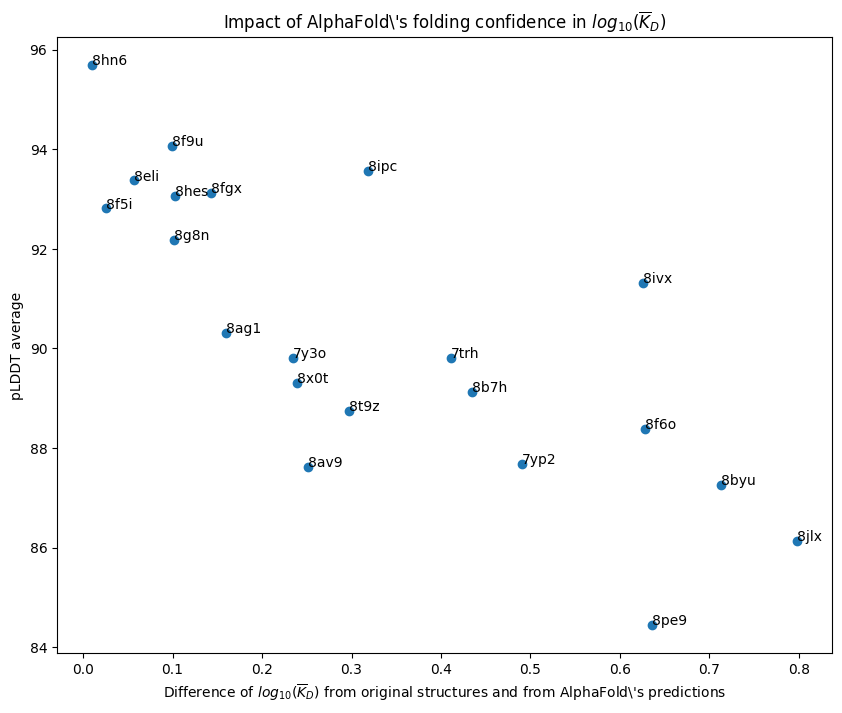

In [201]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.abs(kds_difference), af_plddt)
plt.title(r'Impact of AlphaFold\'s folding confidence in $log_{10}(\overline{K}_D)$')
plt.xlabel(r'Difference of $log_{10}(\overline{K}_D)$ from original structures and from AlphaFold\'s predictions')
plt.ylabel('pLDDT average')

for i, txt in enumerate(test_pdbs):
    plt.annotate(txt, (np.abs(kds_difference[i]), af_plddt[i]))
scipy.stats.spearmanr(np.abs(kds_difference), af_plddt)

SignificanceResult(statistic=0.735064935064935, pvalue=0.00014710767492018793)

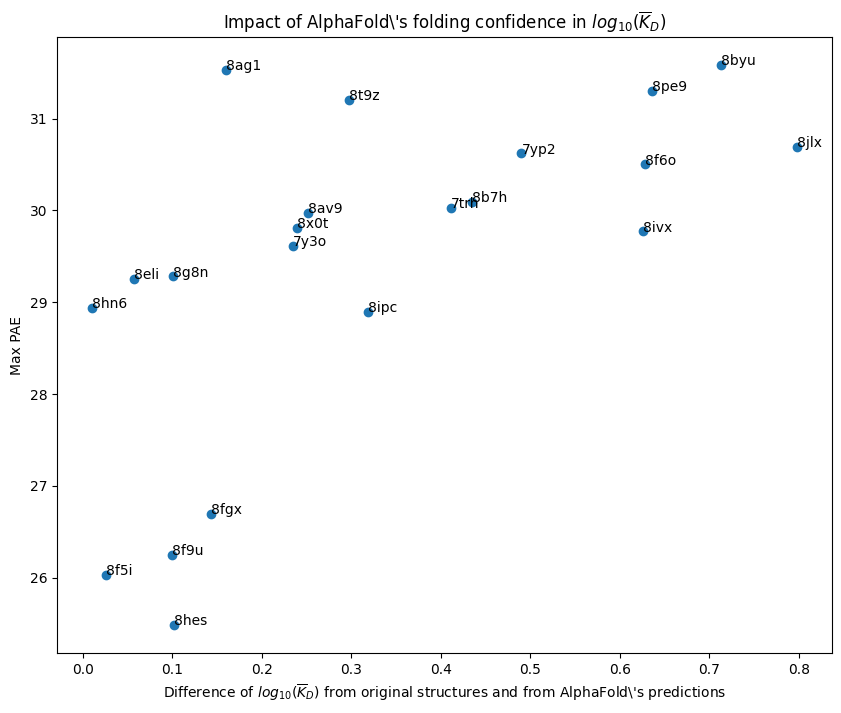

In [203]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.abs(kds_difference), af_max_pae)
plt.title(r'Impact of AlphaFold\'s folding confidence in $log_{10}(\overline{K}_D)$')
plt.xlabel(r'Difference of $log_{10}(\overline{K}_D)$ from original structures and from AlphaFold\'s predictions')
plt.ylabel('Max PAE')

for i, txt in enumerate(test_pdbs):
    plt.annotate(txt, (np.abs(kds_difference[i]), af_max_pae[i]))
scipy.stats.spearmanr(np.abs(kds_difference), af_max_pae)

SignificanceResult(statistic=0.6233766233766234, pvalue=0.0025346926925616134)

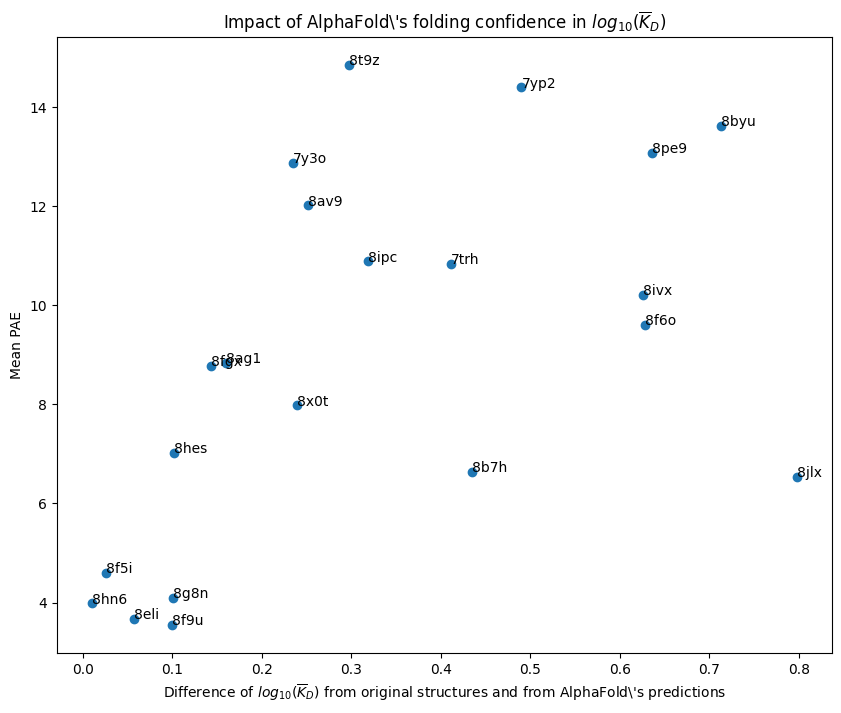

In [191]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.abs(kds_difference), af_mean_pae)
plt.title(r'Impact of AlphaFold\'s folding confidence in $log_{10}(\overline{K}_D)$')
plt.xlabel(r'Difference of $log_{10}(\overline{K}_D)$ from original structures and from AlphaFold\'s predictions')
plt.ylabel('Mean PAE')

for i, txt in enumerate(test_pdbs):
    plt.annotate(txt, (np.abs(kds_difference[i]), af_mean_pae[i]))
scipy.stats.spearmanr(np.abs(kds_difference), af_mean_pae)

SignificanceResult(statistic=0.6896103896103896, pvalue=0.000542956372705794)

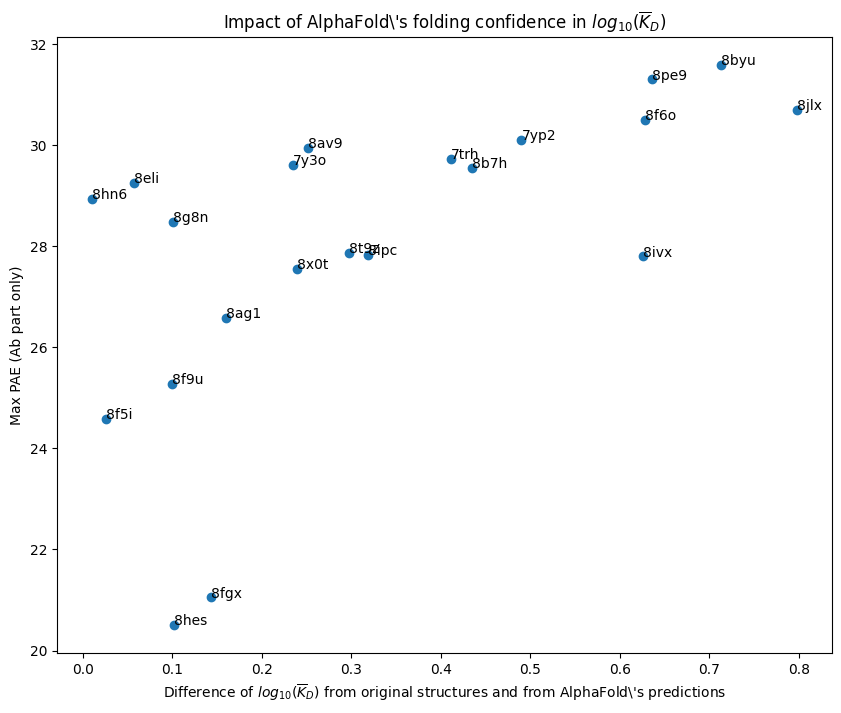

In [192]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.abs(kds_difference), af_max_pae_ab)
plt.title(r'Impact of AlphaFold\'s folding confidence in $log_{10}(\overline{K}_D)$')
plt.xlabel(r'Difference of $log_{10}(\overline{K}_D)$ from original structures and from AlphaFold\'s predictions')
plt.ylabel('Max PAE (Ab part only)')

for i, txt in enumerate(test_pdbs):
    plt.annotate(txt, (np.abs(kds_difference[i]), af_max_pae_ab[i]))
scipy.stats.spearmanr(np.abs(kds_difference), af_max_pae_ab)

SignificanceResult(statistic=0.5025974025974026, pvalue=0.020229828771012277)

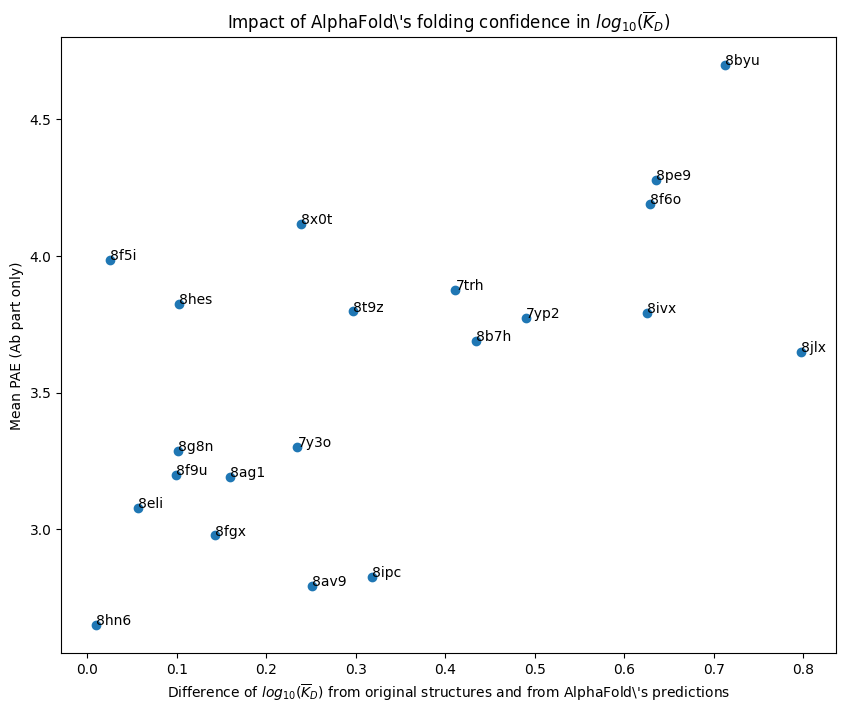

In [193]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.abs(kds_difference), af_mean_pae_ab)
plt.title(r'Impact of AlphaFold\'s folding confidence in $log_{10}(\overline{K}_D)$')
plt.xlabel(r'Difference of $log_{10}(\overline{K}_D)$ from original structures and from AlphaFold\'s predictions')
plt.ylabel('Mean PAE (Ab part only)')

for i, txt in enumerate(test_pdbs):
    plt.annotate(txt, (np.abs(kds_difference[i]), af_mean_pae_ab[i]))

import scipy
scipy.stats.spearmanr(np.abs(kds_difference), af_mean_pae_ab)

SignificanceResult(statistic=0.6753246753246753, pvalue=0.0007815563656282275)

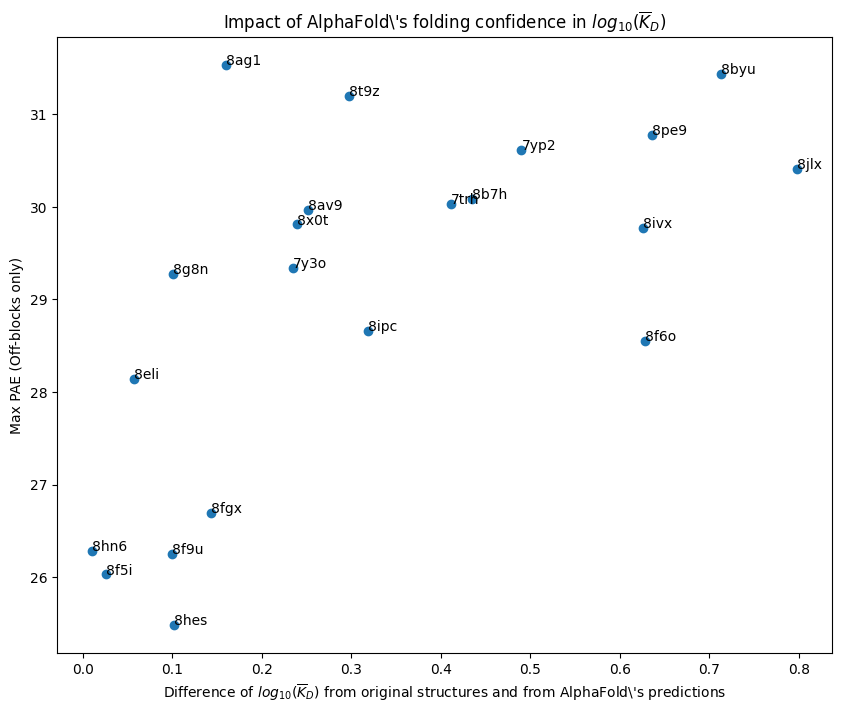

In [194]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.abs(kds_difference), af_max_pae_off_blocks)
plt.title(r'Impact of AlphaFold\'s folding confidence in $log_{10}(\overline{K}_D)$')
plt.xlabel(r'Difference of $log_{10}(\overline{K}_D)$ from original structures and from AlphaFold\'s predictions')
plt.ylabel('Max PAE (Off-blocks only)')

for i, txt in enumerate(test_pdbs):
    plt.annotate(txt, (np.abs(kds_difference[i]), af_max_pae_off_blocks[i]))
scipy.stats.spearmanr(np.abs(kds_difference), af_max_pae_off_blocks)

SignificanceResult(statistic=0.5584415584415584, pvalue=0.008510101872800194)

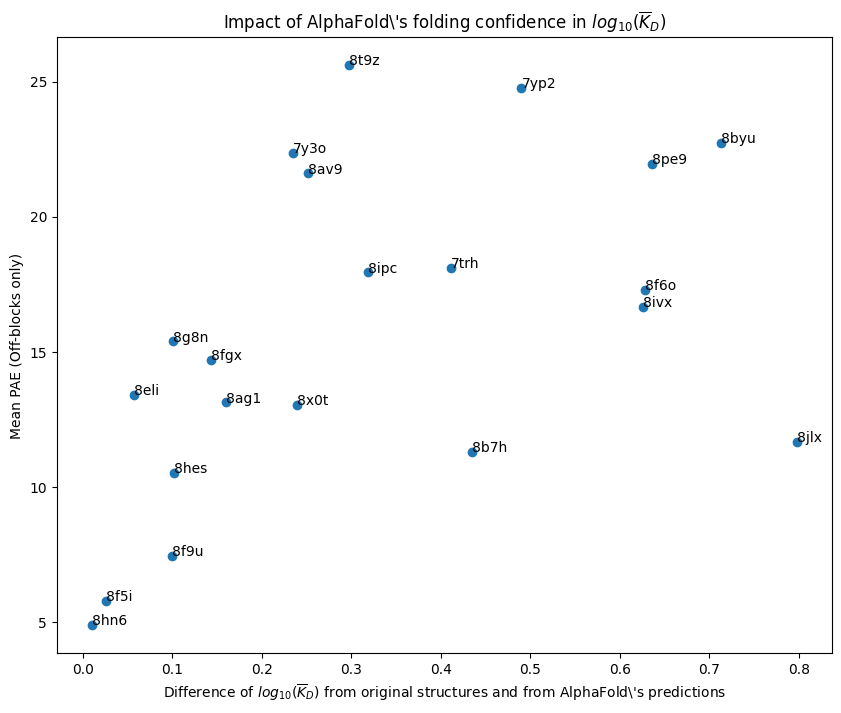

In [195]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.abs(kds_difference), af_mean_pae_off_blocks)
plt.title(r'Impact of AlphaFold\'s folding confidence in $log_{10}(\overline{K}_D)$')
plt.xlabel(r'Difference of $log_{10}(\overline{K}_D)$ from original structures and from AlphaFold\'s predictions')
plt.ylabel('Mean PAE (Off-blocks only)')

for i, txt in enumerate(test_pdbs):
    plt.annotate(txt, (np.abs(kds_difference[i]), af_mean_pae_off_blocks[i]))
scipy.stats.spearmanr(np.abs(kds_difference), af_mean_pae_off_blocks)

SignificanceResult(statistic=0.735064935064935, pvalue=0.00014710767492018793)

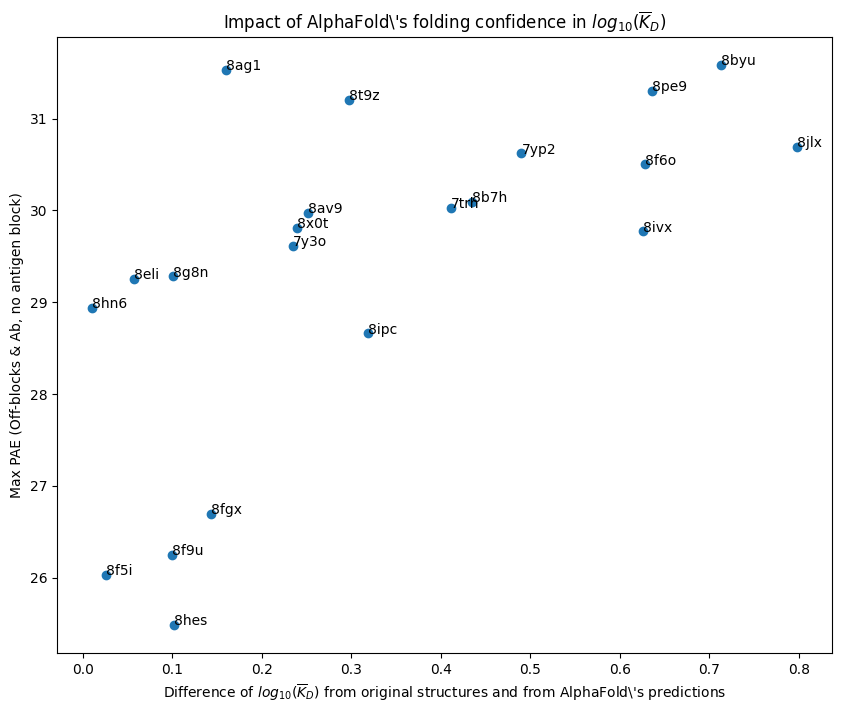

In [196]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.abs(kds_difference), af_max_pae_ab_off_blocks)
plt.title(r'Impact of AlphaFold\'s folding confidence in $log_{10}(\overline{K}_D)$')
plt.xlabel(r'Difference of $log_{10}(\overline{K}_D)$ from original structures and from AlphaFold\'s predictions')
plt.ylabel('Max PAE (Off-blocks & Ab, no antigen block)')

for i, txt in enumerate(test_pdbs):
    plt.annotate(txt, (np.abs(kds_difference[i]), af_max_pae_ab_off_blocks[i]))
scipy.stats.spearmanr(np.abs(kds_difference), af_max_pae_ab_off_blocks)

SignificanceResult(statistic=0.5896103896103897, pvalue=0.004908349532622714)

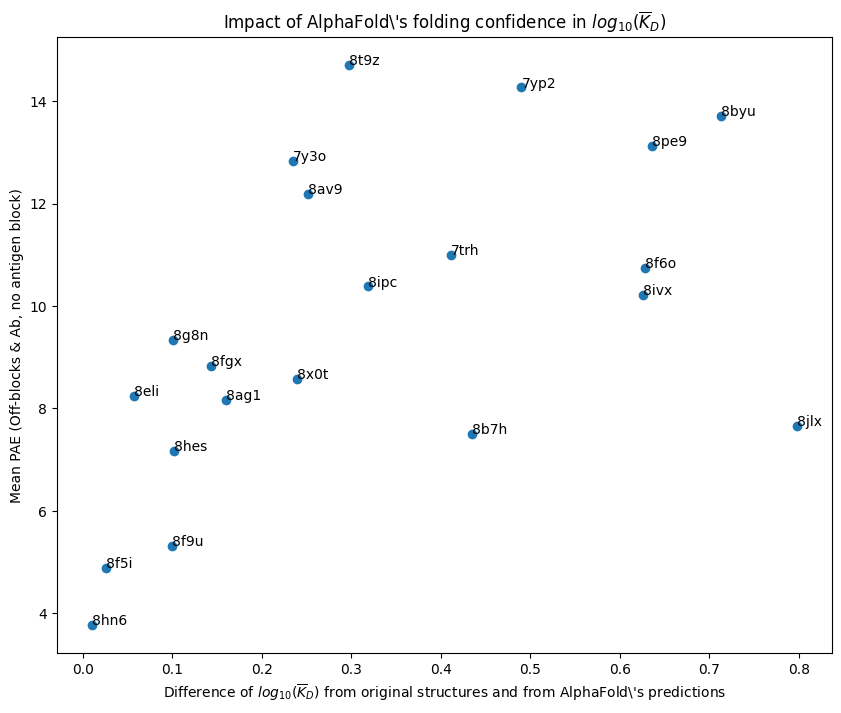

In [197]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.abs(kds_difference), af_mean_pae_ab_off_blocks)
plt.title(r'Impact of AlphaFold\'s folding confidence in $log_{10}(\overline{K}_D)$')
plt.xlabel(r'Difference of $log_{10}(\overline{K}_D)$ from original structures and from AlphaFold\'s predictions')
plt.ylabel('Mean PAE (Off-blocks & Ab, no antigen block)')

for i, txt in enumerate(test_pdbs):
    plt.annotate(txt, (np.abs(kds_difference[i]), af_mean_pae_ab_off_blocks[i]))
scipy.stats.spearmanr(np.abs(kds_difference), af_mean_pae_ab_off_blocks)

In [184]:
#Code to compute Max/Mean of different blocks of PAE matrix

import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

def custom_sort(pdb):
    for code in test_pdbs:
        if pdb.startswith(code):
            return test_pdbs.index(code)
    return len(test_pdbs)

def calculate_metrics(matrix, n):
    # 1. Max and mean of the error_matrix
    max_matrix = np.max(matrix)
    mean_matrix = np.mean(matrix)
    
    # 2. Max of a block 0:n, 0:n
    max_block_ab = np.max(matrix[:n, :n])
    
    # 3. Mean of a block 0:n, 0:n
    mean_block_ab = np.mean(matrix[:n, :n])
    
    # 4. Max of two blocks: 0:n, n:end and n:end, 0:n
    if np.size(matrix[:n, n:]) != 0:
        max_block_offb = np.max([np.max(matrix[:n, n:]), np.max(matrix[n:, :n])])
    else:
        max_block_offb = np.nan
    
    # 5. Mean of two blocks: 0:n, n:end and n:end, 0:n
    mean_block_offb = np.mean([np.mean(matrix[:n, n:]), np.mean(matrix[n:, :n])])
    
    # 6. Max of the block in 2 and the two blocks of 4
    max_combined = np.max([max_block_ab, max_block_offb])
    
    # 7. Mean instead of Max for 6
    mean_combined = np.mean([mean_block_ab, mean_block_offb])
    
    return max_matrix, mean_matrix, max_block_ab, mean_block_ab, max_block_offb, mean_block_offb, max_combined, mean_combined


main_directory = '/Users/kevinmicha/Documents/PhD/Results/AlphaFold results/'
af_max_pae = []
af_mean_pae = []
af_max_pae_ab = []
af_mean_pae_ab = []
af_max_pae_off_blocks = []
af_mean_pae_off_blocks = []
af_max_pae_ab_off_blocks = []
af_mean_pae_ab_off_blocks = []

for i, path in enumerate(sorted(os.listdir(main_directory), key=custom_sort)):
    if path not in ['Old', '.DS_Store'] and path[-4:] != '.pse':
        with open(glob.glob(os.path.join(main_directory, f'{path}/{path}_scores_rank_001_alphafold2_multimer_v3_model_*_seed_00*.json'))[0], 'r') as json_file:
            data = json.load(json_file)

        # Extract the 'predicted_aligned_error' field
        error_data = data['pae']

        # Convert error_data to a NumPy array for plotting
        error_matrix = np.array(error_data)
        
        with open(main_directory+path+'/'+path+'.csv', 'r') as csv_file:
            csv_reader = csv.DictReader(csv_file)
            for row in csv_reader:
                sequence = row['sequence']
                break  # We assume there's only one entry in the CSV
        print(path[0:4])
        # Find the index of the first ':' character to determine n
        if path[0:4] == '2p45':
            n = sequence.index(':')
        else:
            second_colon_index = sequence.find(':', sequence.find(':') + 1)
            if second_colon_index == -1:
                n = len(sequence)
            else:
                n = second_colon_index
        if path[0:4] == '4f3f':
            print(error_matrix)
            
        metrics = calculate_metrics(error_matrix, n)

        af_max_pae.append(metrics[0])
        af_mean_pae.append(metrics[1]) 
        af_max_pae_ab.append(metrics[2])
        af_mean_pae_ab.append(metrics[3])
        af_max_pae_off_blocks.append(metrics[4])
        af_mean_pae_off_blocks.append(metrics[5])
        af_max_pae_ab_off_blocks.append(metrics[6])
        af_mean_pae_ab_off_blocks.append(metrics[7])

        print(','.join(map(str, metrics)))

        # Create a figure and axis
        #fig, ax = plt.subplots(figsize=(10, 8))

        # Plot the error_matrix using imshow
        #cax = ax.imshow(error_matrix, cmap='viridis', aspect='auto')

        # Add a colorbar
        #cbar = fig.colorbar(cax)

        # Add labels and title
        #plt.xlabel('Position')
        #plt.ylabel('Row')
        #plt.title('Predicted Aligned Error Matrix')

        #plt.tight_layout()
        #plt.show()

8g8n
29.28,4.088104499963475,28.48,3.286793210118255,29.28,15.385832411504424,29.28,9.33631281081134
8ipc
28.89,10.881952999811482,27.83,2.826893061320385,28.66,17.940997835188888,28.66,10.383945448254636
7yp2
30.62,14.391471004575399,30.11,3.7732126213413397,30.62,24.759056548149573,30.62,14.266134584745457
8jlx
30.69,6.530943400622023,30.69,3.6500025679012342,30.41,11.676542483660132,30.69,7.663272525780683
8b7h
30.09,6.642379916753382,29.55,3.6897284979259024,30.09,11.300952257094966,30.09,7.495340377510434
7y3o
29.61,12.86780163321799,29.61,3.301873142092747,29.34,22.37053533142755,29.61,12.83620423676015
8x0t
29.81,7.975190055275524,27.55,4.11706644071543,29.81,13.02873245071652,29.81,8.572899445715976
8t9z
31.2,14.838989750554383,27.86,3.7971066777930877,31.2,25.601841455224303,31.2,14.699474066508696
8hes
25.48,7.0113006127532,20.5,3.824126573110005,25.48,10.506244179570013,25.48,7.165185376340009
8f9u
26.25,3.5407267029638834,25.27,3.199628344234473,26.25,7.4395982532751095,26.

In [185]:
# Get mean pLDDT
af_plddt = []

for i, path in enumerate(sorted(os.listdir(main_directory), key=custom_sort)):
    if path not in ['Old', '.DS_Store'] and path[-4:] != '.pse':
        af_plddt.append(np.load(glob.glob(os.path.join(main_directory, f'{path}/{path}_all_rank_001_alphafold2_multimer_v3_model_*_seed_00*.pickle'))[0], allow_pickle=True)['mean_plddt'].item())